In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=87b449bf37a126ea87ec8b250ea8d70b8db6890b2866d8adbd58ef4380cc039e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Heart Disease Prediction") \
    .getOrCreate()


In [3]:
file_path = "/content/heart_disease_health_indicators_BRFSS2015.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)
df.count()

root
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- Diabetes: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)

+--------------------+------+--------+---------+----+------+------+--------+------------+------+-------+--

253680

# Exploratory Data Analysis

In [4]:
from pyspark.sql.functions import col, count, when

# Check for missing values in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+--------------------+------+--------+---------+---+------+------+--------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|HeartDiseaseorAttack|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|Diabetes|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+--------------------+------+--------+---------+---+------+------+--------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|                   0|     0|       0|        0|  0|     0|     0|       0|           0|     0|      0|                0|            0|          0|      0|       0|       0|       0|  0|  0|        0|     0|
+--------------------+------+--------+---------+---+------+------+--------+------------+------+-------+-----------------+-------------+-----------+-------+--------+----

In [5]:
# Example: Analyzing the distribution of the 'Sex' category
df.groupBy('Sex').count().show()

# Example: Analyzing the distribution of the 'Education' category
df.groupBy('Education').count().show()


+---+------+
|Sex| count|
+---+------+
|0.0|141974|
|1.0|111706|
+---+------+

+---------+------+
|Education| count|
+---------+------+
|      1.0|   174|
|      4.0| 62750|
|      3.0|  9478|
|      2.0|  4043|
|      6.0|107325|
|      5.0| 69910|
+---------+------+



In [6]:
from pyspark.sql.functions import col

# Example: Calculate percentages for the 'Smoker' category
df.groupBy('Smoker').count().withColumn('percentage', col('count') / df.count() * 100).show()


+------+------+-----------------+
|Smoker| count|       percentage|
+------+------+-----------------+
|   0.0|141257|55.68314411857458|
|   1.0|112423|44.31685588142542|
+------+------+-----------------+



In [7]:
# List of numeric columns to examine correlation
numeric_cols = ['BMI', 'Age', 'HeartDiseaseorAttack', 'PhysActivity', 'Income']

# Calculate correlation matrix
for i in numeric_cols:
    for j in numeric_cols:
        if i != j:
            print(f"Correlation between {i} and {j}: {df.stat.corr(i, j)}")


Correlation between BMI and Age: -0.03661763519792282
Correlation between BMI and HeartDiseaseorAttack: 0.052904256455539006
Correlation between BMI and PhysActivity: -0.14729363356752118
Correlation between BMI and Income: -0.10006871034512743
Correlation between Age and BMI: -0.03661763519792285
Correlation between Age and HeartDiseaseorAttack: 0.22161763244723479
Correlation between Age and PhysActivity: -0.09251063330118683
Correlation between Age and Income: -0.1277752779030364
Correlation between HeartDiseaseorAttack and BMI: 0.05290425645553902
Correlation between HeartDiseaseorAttack and Age: 0.22161763244723473
Correlation between HeartDiseaseorAttack and PhysActivity: -0.0872989869245247
Correlation between HeartDiseaseorAttack and Income: -0.14101123143378871
Correlation between PhysActivity and BMI: -0.14729363356752118
Correlation between PhysActivity and Age: -0.09251063330118679
Correlation between PhysActivity and HeartDiseaseorAttack: -0.08729898692452469
Correlation b

In [8]:
# Correlation between 'BMI' and 'HeartDiseaseorAttack'
df.stat.corr('BMI', 'HeartDiseaseorAttack')

# Correlation between 'Age' and 'HeartDiseaseorAttack'
df.stat.corr('Age', 'HeartDiseaseorAttack')


0.22161763244723479

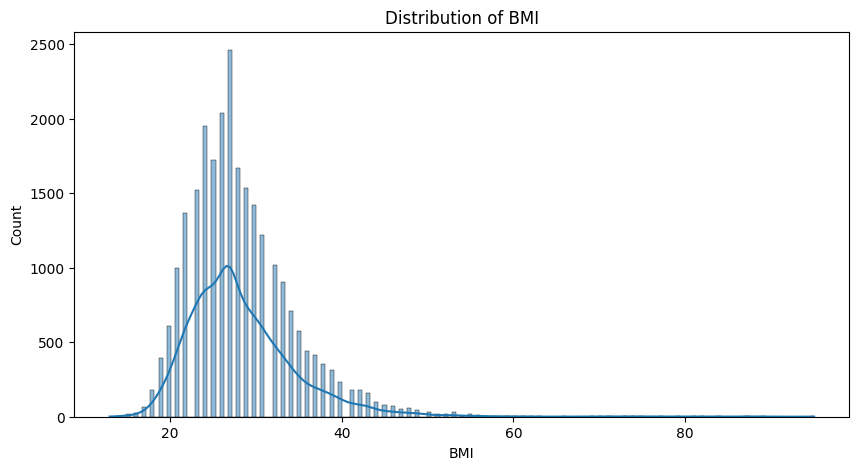

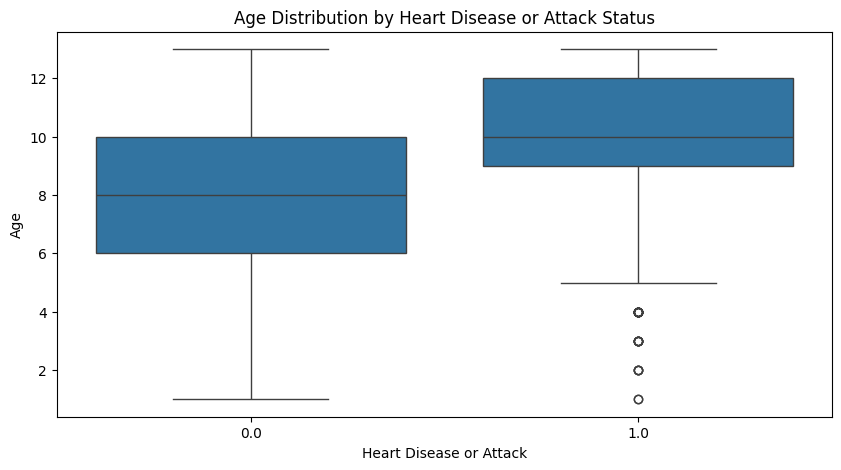

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample a fraction of the data for visualization
sample_pdf = df.sample(withReplacement=False, fraction=0.1).toPandas()

# Histogram of BMI
plt.figure(figsize=(10, 5))
sns.histplot(sample_pdf['BMI'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

# Boxplot for Age grouped by HeartDiseaseorAttack
plt.figure(figsize=(10, 5))
sns.boxplot(x='HeartDiseaseorAttack', y='Age', data=sample_pdf)
plt.title('Age Distribution by Heart Disease or Attack Status')
plt.xlabel('Heart Disease or Attack')
plt.ylabel('Age')
plt.show()


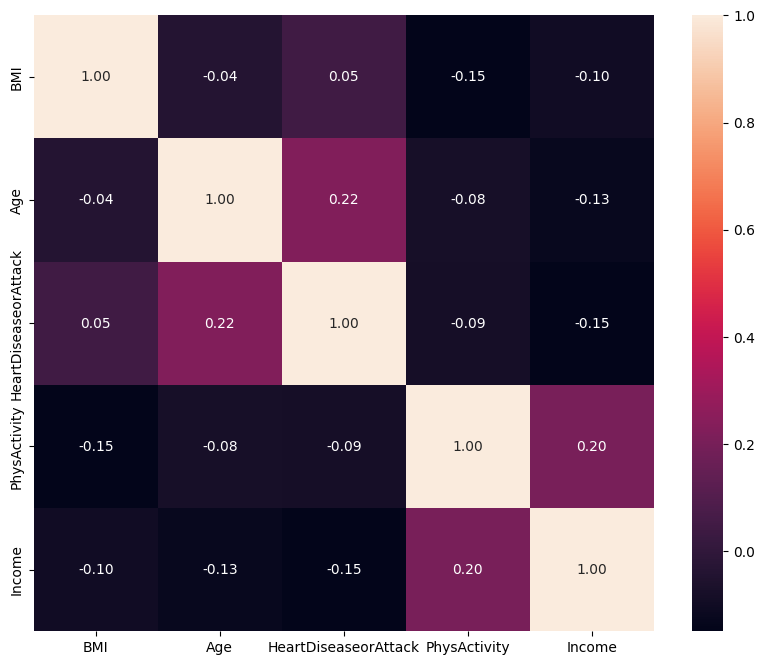

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume sample_pdf is a sampled Pandas DataFrame of your Spark DataFrame
corr = sample_pdf[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()


In [11]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# List of all feature columns, excluding the target variable "HeartDiseaseorAttack"
feature_cols = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes',
                'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex',
                'Age', 'Education', 'Income']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Since there are no categorical variables to index, we can proceed directly to assembling and scaling
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the pipeline on your DataFrame
pipelineModel = pipeline.fit(df)
df_transformed = pipelineModel.transform(df)

# Assuming "HeartDiseaseorAttack" is your label column, prepare for model training
df_transformed = df_transformed.withColumnRenamed("HeartDiseaseorAttack", "label")

In [12]:
(train_data, test_data) = df_transformed.randomSplit([0.7, 0.3])

# Random Forest Classifier

In [13]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures", numTrees=10)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)


In [14]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator with accuracy as the metric
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Now you can use the evaluator to compute the model's accuracy
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy*100:.2f}%")


Random Forest Accuracy: 90.49%


# Decision Tree Classifier

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaledFeatures")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy*100:.2f}%")

Decision Tree Accuracy: 90.64%


# Linear Regression

In [16]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize and fit the Linear Regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="label")
lr_model = lr.fit(train_data)

# Transform the test data using the trained linear regression model
lr_predictions = lr_model.transform(test_data)

# Evaluate the model using RMSE as the metric
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

# Print the RMSE to assess the model's performance
print(f"Linear Regression: {lr_rmse*100:.2f}")

Linear Regression: 27.05


# Gradient-Boosted Trees (GBT)

In [17]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="scaledFeatures", maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"GBT Accuracy: {gbt_accuracy*100:.2f}%")

GBT Accuracy: 30.50%


In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator with various metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

# Dictionary to store results
model_metrics = {}

# List of models and their predictions
models = {
    "Random Forest": rf_predictions,
    "Decision Tree": dt_predictions,
    "GBT": gbt_predictions
}

# Calculate metrics
for name, predictions in models.items():
    model_metrics[name] = {metric: evaluator.evaluate(predictions, {evaluator.metricName: metric}) for metric in metrics}

# Print the calculated metrics for each model
for model, metrics in model_metrics.items():
    print(f"{model} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print("\n")

Random Forest Performance:
accuracy: 0.90
weightedPrecision: 0.82
weightedRecall: 0.90
f1: 0.86


Decision Tree Performance:
accuracy: 0.91
weightedPrecision: 0.88
weightedRecall: 0.91
f1: 0.87


GBT Performance:
accuracy: 0.91
weightedPrecision: 0.88
weightedRecall: 0.91
f1: 0.87




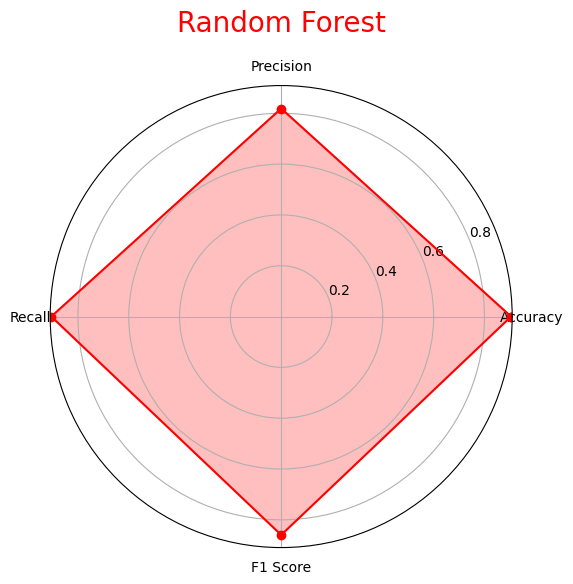

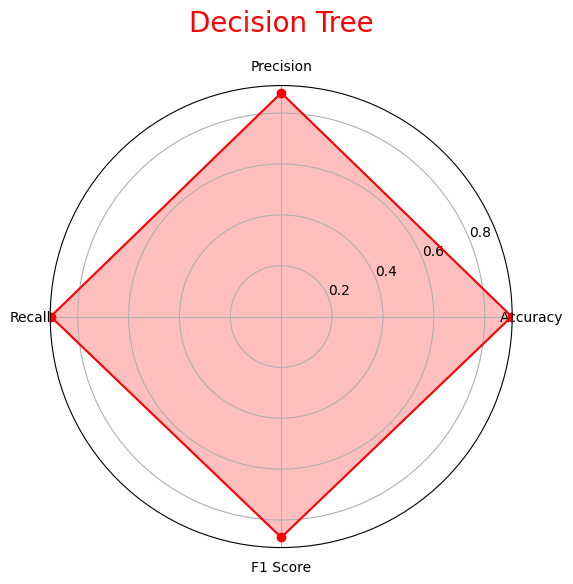

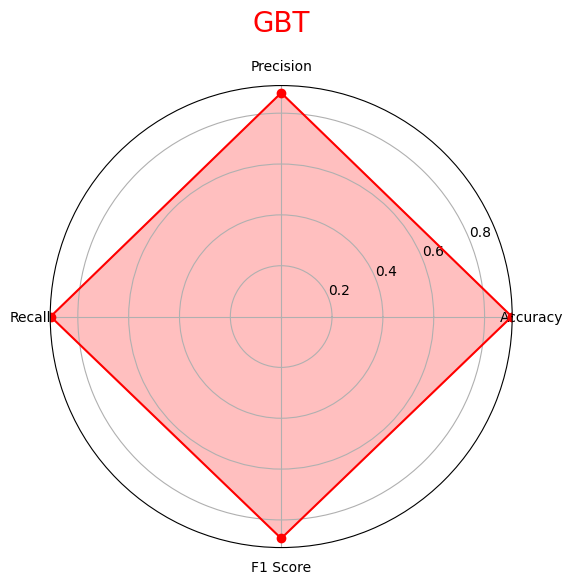

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create a radar chart
def make_radar_chart(name, stats, attribute_labels, plot_markers, plot_str_markers):
    labels = np.array(attribute_labels)
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    stats += stats[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, stats, color='red', alpha=0.25)
    ax.plot(angles, stats, color='red', marker='o')  # Line
    plt.title(name, size=20, color='red', y=1.1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Attributes labels and markers
attributes = ["Accuracy", "Precision", "Recall", "F1 Score"]
markers = [1, 1, 1, 1]  # adjust based on your scale
str_markers = ["1", "1", "1", "1"]

# Plot for each model
for model, values in model_metrics.items():
    stats = [values[metric] for metric in metrics]
    make_radar_chart(model, stats, attributes, markers, str_markers)

plt.show()


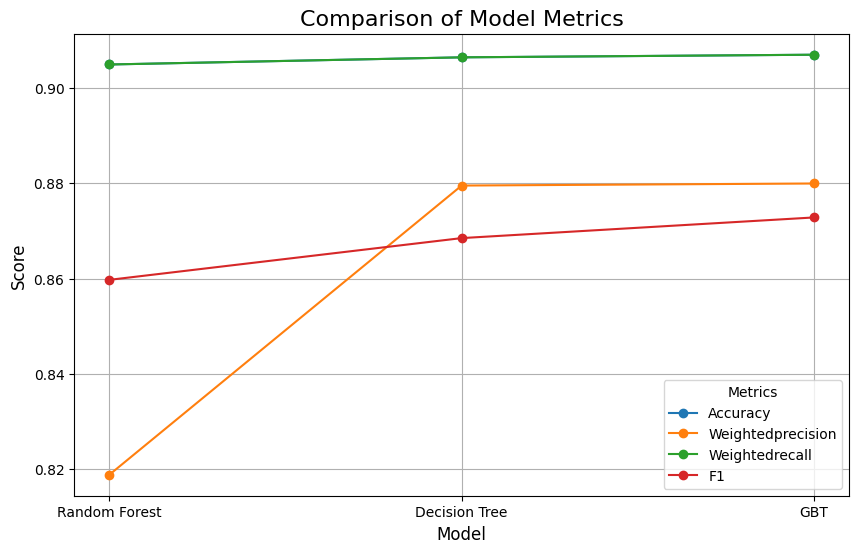

In [20]:
import matplotlib.pyplot as plt

# Assuming model_metrics is defined with lowercase keys as it often comes from PySpark evaluation
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]
model_names = ["Random Forest", "Decision Tree", "GBT"]

# Prepare data for plotting assuming keys are in lowercase
plot_data = {metric: [model_metrics[model][metric] for model in model_names] for metric in metrics}

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Each metric will have its own plot line
for metric in metrics:
    ax.plot(model_names, plot_data[metric], marker='o', label=metric.capitalize())

# Adding labels and title
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparison of Model Metrics', fontsize=16)
ax.legend(title='Metrics')

# Display the plot
plt.grid(True)
plt.xticks(model_names)
plt.show()